In [6]:
import sys
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Feb 11 2019, 15:03:47) [MSC v.1915 64 bit (AMD64)]


In [1]:
# Importing dependencies
import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import data_prep_helper
plt.style.use('ggplot')

Using TensorFlow backend.


### Data Preprocessing

In [2]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [3]:
# Loading the dataset
do = data_prep_helper.ShiftChartData(chart_col=["Price", "High", "Low"])

In [4]:
df = do.get_causal_const_shift(do.chart_df)

In [5]:
df.head()

,bitcoin_Price,bitcoin_High,bitcoin_Low,sp500_Price,sp500_High,sp500_Low,dax_Price,dax_High,dax_Low,googl_Price,...,googl_High_prev_week,googl_High_prev_month,googl_Low_prev_week,googl_Low_prev_month,bitcoin_Google_Trends_prev_week,bitcoin_Google_Trends_prev_month,cryptocurrency_Google_Trends_prev_week,cryptocurrency_Google_Trends_prev_month,economy_pos_sents_prev_week,economy_pos_sents_prev_month
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-08,282.7,292.7,279.0,2062.14,2064.08,2030.61,9837.61,9855.43,9607.90,506.91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-09,288.0,290.6,277.3,2044.81,2064.43,2038.33,9648.50,9860.18,9601.75,500.72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-12,269.3,273.1,263.3,2028.26,2049.30,2022.58,9781.90,9815.96,9622.32,497.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-13,221.3,269.1,217.1,2023.03,2056.93,2008.25,9941.00,9978.94,9755.02,501.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-14,164.9,230.9,157.3,2011.27,2018.40,1988.44,9817.08,9962.98,9768.10,505.93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df.columns

Index(['bitcoin_Price', 'bitcoin_High', 'bitcoin_Low', 'sp500_Price',
       'sp500_High', 'sp500_Low', 'dax_Price', 'dax_High', 'dax_Low',
       'googl_Price', 'googl_High', 'googl_Low', 'gold_Price', 'gold_High',
       'gold_Low', 'alibaba_Price', 'alibaba_High', 'alibaba_Low',
       'amazon_Price', 'amazon_High', 'amazon_Low', 'bitcoin_Google_Trends',
       'cryptocurrency_Google_Trends', 'trading_Google_Trends',
       'bitcoin_pos_sents', 'bitcoin_neg_sents', 'bitcoin_quot_sents',
       'economy_pos_sents', 'economy_neg_sents', 'economy_quot_sents',
       'month-1', 'month-2', 'month-3', 'bitcoin_Price_prev_week',
       'bitcoin_Price_prev_month', 'bitcoin_High_prev_week',
       'bitcoin_High_prev_month', 'bitcoin_Low_prev_week',
       'bitcoin_Low_prev_month', 'alibaba_Price_prev_week',
       'alibaba_Price_prev_month', 'alibaba_High_prev_week',
       'alibaba_High_prev_month', 'alibaba_Low_prev_week',
       'alibaba_Low_prev_month', 'amazon_Price_prev_week',
       '

In [6]:
# Correlation matrix
df.corr()['bitcoin_Price']

bitcoin_Price                              1.000000
bitcoin_High                               0.998878
bitcoin_Low                                0.998444
sp500_Price                                0.845476
sp500_High                                 0.847199
                                             ...   
bitcoin_Google_Trends_prev_month           0.665822
cryptocurrency_Google_Trends_prev_week     0.628953
cryptocurrency_Google_Trends_prev_month    0.631026
economy_pos_sents_prev_week                0.570798
economy_pos_sents_prev_month               0.517859
Name: bitcoin_Price, Length: 63, dtype: float64

In [7]:
print(df.describe()["bitcoin_High"]) 
df.drop(df[df["bitcoin_High"]==0].index, inplace = True) #Dropping rows with volume value 0

count     1274.000000
mean      4244.355102
std       4134.456446
min        216.600000
25%        451.275000
50%       2939.400000
75%       7634.175000
max      19221.100000
Name: bitcoin_High, dtype: float64


In [8]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [9]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse,rmse, r2, Y_test, Y_hat
  

In [10]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [11]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [20]:
# Extracting the series
series = df[['bitcoin_Price_prev_week',
             'bitcoin_High_prev_week',
             'bitcoin_Low_prev_week',
             'alibaba_Price_prev_week',
             'alibaba_High_prev_week',
             'bitcoin_Google_Trends_prev_week',
             'cryptocurrency_Google_Trends_prev_week',
             'month-1']] # Picking the features
print(series.shape)
print(series.tail())

(1274, 8)
            bitcoin_Price_prev_week  bitcoin_High_prev_week  \
Date                                                          
2020-03-04                   9684.5                  9747.1   
2020-03-05                   9662.7                  9981.0   
2020-03-06                   9317.2                  9672.3   
2020-03-09                   8800.3                  9368.1   
2020-03-10                   8818.6                  8968.3   

            bitcoin_Low_prev_week  alibaba_Price_prev_week  \
Date                                                         
2020-03-04                 9574.5                   212.59   
2020-03-05                 9507.0                   206.16   
2020-03-06                 9269.8                   205.61   
2020-03-09                 8672.0                   208.74   
2020-03-10                 8538.5                   205.03   

            alibaba_High_prev_week  bitcoin_Google_Trends_prev_week  \
Date                                      

In [21]:
'''
# Train Val Test Split
train_start = dt.date(1997,1,1)
train_end = dt.date(2006,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2007,1,1)
val_end = dt.date(2008,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2009,1,1)
test_end = dt.date(2010,12,31)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)
'''

'\n# Train Val Test Split\ntrain_start = dt.date(1997,1,1)\ntrain_end = dt.date(2006,12,31)\ntrain_data = series.loc[train_start:train_end]\n\nval_start = dt.date(2007,1,1)\nval_end = dt.date(2008,12,31)\nval_data = series.loc[val_start:val_end]\n\ntest_start = dt.date(2009,1,1)\ntest_end = dt.date(2010,12,31)\ntest_data = series.loc[test_start:test_end]\n\nprint(train_data.shape,val_data.shape,test_data.shape)\n'

In [22]:
#creating the train and validation set
train = series[:int(0.7*(len(series)))]
val = series[int(0.7*(len(series))):int(0.85*(len(series)))]
test = series[int(0.85*(len(series))):]

In [23]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train)
val = sc.transform(val)
test = sc.transform(test)
print(train.shape,val.shape,test.shape)

(891, 8) (191, 8) (192, 8)


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [24]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

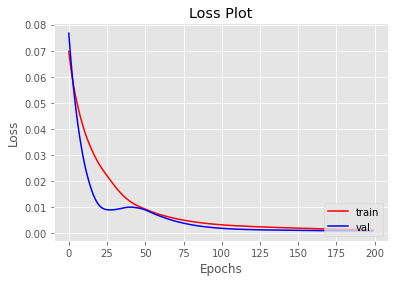

In [25]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.003004029982368279
RMSE = 0.054809031941535684
R2-Score = 0.2984443467841382


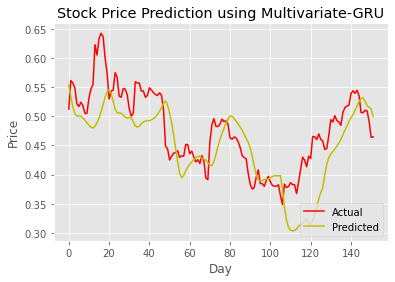

In [26]:
mse,rmse,r2_value,true,predicted = evaluate_model(model,test,40)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [17]:
# Save a model
model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
#del model  #Deletes the model
# Load a model
#model = load_model('MV3-GRU_40_[40,35]_1e-4_64.h5')

## Cross Validation

In [42]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 50

In [43]:
# Extracting the series
series = df[['Price','High','Low']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(1903, 3)
             Price    High     Low
Date                              
2020-03-13  5584.3  5934.3  3869.5
2020-03-14  5182.7  5634.9  5072.2
2020-03-15  5366.3  5863.3  5120.6
2020-03-16  5030.0  5369.3  4477.7
2020-03-17  5271.3  5405.7  4946.5


In [45]:
series.shape

(1903, 3)

In [44]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:1800])
series

array([[0.0078204 , 0.00553464, 0.00840074],
       [0.00783604, 0.00528029, 0.00837923],
       [0.00637102, 0.00524977, 0.00686258],
       ...,
       [0.27118026, 0.2874504 , 0.26693593],
       [0.25364691, 0.26232068, 0.23235952],
       [0.26622733, 0.26417235, 0.2575725 ]])

### Split I

In [47]:
#Splitting the data for initial model creation
splits = 5
split_size = 300
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

Split 1
MSE = 0.1037102627187491
RMSE = 0.322040778037113
R-Squared Score = -1.414452608415341


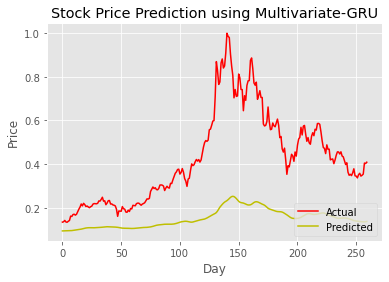

In [50]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train, test,timesteps,hl,lr,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.save("MV3-GRU-Split1.h5")

### Split II

Split 2
MSE = 0.005008777063320799
RMSE = 0.07077271411582856
R-Squared Score = 0.1421053957559455


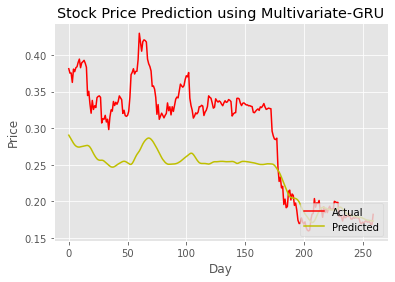

In [51]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split2.h5")

### Split III

Split 3
MSE = 0.0009685389941875315
RMSE = 0.031121359131431447
R-Squared Score = 0.9213075003891268


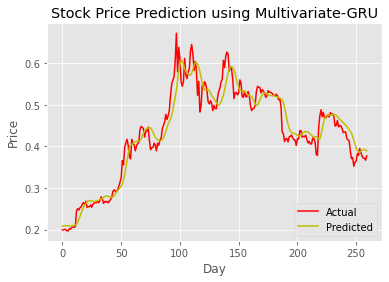

In [52]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
val_loss["Split3"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split3.h5")

In [ ]:
CV_results.to_csv('MV3-GRU_CrossValidation.csv')
train_loss.to_csv('MV3-GRU_CrossValidation_TrainLoss.csv')
val_loss.to_csv('MV3-GRU_CrossValidation_ValLoss.csv')